In [ ]:
# Install RAPIDS (takes ~10 min).
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

# https://github.com/NVIDIA/NVTabular/blob/main/examples/winning-solution-recsys2020-twitter/01-02-04-Download-Convert-ETL-with-NVTabular-Training-with-XGBoost.ipynb     

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 205 (delta 16), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (205/205), 62.72 KiB | 12.54 MiB/s, done.
Resolving deltas: 100% (78/78), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals

In [ ]:
# Needed to fix conda and install nvtabular.
!conda install https://repo.anaconda.com/pkgs/main/linux-64/conda-4.9.2-py37h06a4308_0.tar.bz2
!pip install git+https://github.com/NVIDIA/NVTabular.git@main


conda-4.9.2          | : 100% 1.0/1 [00:00<00:00,  1.07it/s]
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
  Cloning https://github.com/NVIDIA/NVTabular.git (to revision main) to /tmp/pip-req-build-br38tz9p
  Running command git clone -q https://github.com/NVIDIA/NVTabular.git /tmp/pip-req-build-br38tz9p
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nvtabular: filename=nvtabular-0.4.0+19.gdd1c8b6-py3-none-any.whl size=206846 sha256=bae2fbce696a4cfab72bd05ddd5700b0ad848623716f6ec3dd348dea587df32d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q00_k0s6/wheels/32/74/7c/e2d323de42120f4cefc10fb3fe2543f6c7558bf7c7b3a021c5
Successfully built nvtabular


In [ ]:
# External Dependencies
import time
import glob
import gc

import cupy as cp          # CuPy is an implementation of NumPy-compatible multi-dimensional array on GPU
import cudf                # cuDF is an implementation of Pandas-like Dataframe on GPU
import rmm                 # library for pre-allocating memory on GPU
import dask                # dask is an open-source library to nateively scale Python on multiple workers/nodes
import dask_cudf           # dask_cudf uses dask to scale cuDF dataframes on multiple workers/nodes

import numpy as np
# NVTabular is the core library, we will use here for feature engineering/preprocessing on GPU
import nvtabular as nvt
import xgboost as xgb

# More dask / dask_cluster related libraries to scale NVTabular
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.distributed import wait
from dask.utils import parse_bytes
from dask.delayed import delayed
from nvtabular.utils import device_mem_size
from nvtabular.column_group import ColumnGroup

In [ ]:
!nvidia-smi

Mon Apr  5 17:01:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Assume dataset in MyDrive/RecSys2021
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/RecSys2021/'

time_total_start = time.time()

Mounted at /content/drive


In [ ]:
cluster = LocalCUDACluster(
    protocol="tcp"
)
client = Client(cluster)
client

/usr/local/lib/python3.7/site-packages/distributed/client.py:1140: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:41607 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 12.72 GiB


In [ ]:
# Setting locale for pretty printing
import locale
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

In [ ]:
# Importing something that can be useful, I hope
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 110
import pandas as pd
import numpy as np

# Train dataset analysis

In [ ]:
# Load the data (from notebook NVTabular_Preprocessing_Analysis)
dataframe = dask_cudf.read_parquet(BASE_DIR + 'preprocess_analysis/*.parquet')
if 'text_tokens' in list(dataframe.columns):
    dataframe  = dataframe.drop('text_tokens', axis=1)

old_columns = ['like_engagement', 'retweet_engagement', 'reply_engagement', 'retweet_comment_engagement']
new_columns = ['tweet_feature_engagement_is_like', 'tweet_feature_engagement_is_retweet', 'tweet_feature_engagement_is_reply', 'tweet_feature_engagement_is_comment']
dataframe = dataframe.rename(columns=dict(zip(old_columns, new_columns)))

dataframe["tweet_feature_engagement_is_positive"] = (dataframe['tweet_feature_engagement_is_like'] | dataframe['tweet_feature_engagement_is_retweet']|
                                                     dataframe['tweet_feature_engagement_is_reply'] | dataframe['tweet_feature_engagement_is_comment']).astype('int8')
dataframe["tweet_feature_engagement_is_negative"] = (1 - dataframe['tweet_feature_engagement_is_positive']).astype('int8')
dataframe = dataframe.compute()                                                     

pd.set_option('display.max_rows', 100)
dataframe.head(20)

,hashtags_count_t,domains_count_t,links_count_t,media,hashtags,domains,links,language,tweet_type,tweet_id,a_user_id,b_user_id,reply,retweet,retweet_comment,like,timestamp_wd,tweet_feature_engagement_is_reply,tweet_feature_engagement_is_retweet,tweet_feature_engagement_is_comment,tweet_feature_engagement_is_like,timestamp_hour,timestamp_minute,timestamp_second,tweet_type_raw,timestamp,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a,tweet_feature_engagement_is_positive,tweet_feature_engagement_is_negative
0,0,0,0,0,1,1,1,20,2,2883132,2513097,824160,0,0,0,0,5,0,0,0,0,17,23,54,Retweet,1613237034,2473,662,False,1261859734,169,339,False,1520886748,False,0,1
1,0,1,1,0,1,66233,113401,47,3,1334478,2570055,2579677,0,0,0,0,4,0,0,0,0,15,30,0,TopLevel,1613748600,4418640,228,True,1266804490,393,1190,False,1237570695,False,0,1
2,0,1,1,0,1,89689,518494,47,3,3696548,51913,4887078,0,0,0,1613388292,0,0,0,0,1,10,50,38,TopLevel,1613386238,219715,3685,True,1202617218,629,1473,False,1263176351,False,1,0
3,0,0,0,0,1,1,1,47,2,6214352,520585,4204396,0,0,0,0,4,0,0,0,0,4,24,0,Retweet,1613708640,2388283,13511,True,1251645191,123,200,False,1268276559,False,0,1
4,0,0,0,6,1,1,1,62,3,1369771,2450631,95473,0,0,0,1612587384,5,0,0,0,1,4,33,38,TopLevel,1612586018,414,720,False,1578273274,134,379,False,1483862063,True,1,0
5,0,0,0,0,1,1,1,11,1,6899501,344779,2294250,0,0,0,0,3,0,0,0,0,12,40,51,Quote,1613047251,673,561,False,1318013852,2322,996,False,1385942383,True,0,1
6,0,0,0,0,1,1,1,20,2,6113270,3287803,1181513,0,0,0,0,0,0,0,0,0,10,3,49,Retweet,1613383429,9879,95,False,1551982041,61,1008,False,1573893335,False,0,1
7,0,0,0,0,1,1,1,20,1,3702352,456052,297643,0,0,0,1614134640,2,0,0,0,1,2,10,56,Quote,1614132656,209681,141,False,1516334262,35,106,False,1581377629,False,1,0
8,0,0,0,0,1,1,1,47,2,6867952,328331,2308414,0,0,0,0,2,0,0,0,0,15,5,38,Retweet,1614179138,901,782,False,1401492344,9661,8573,False,1373060291,True,0,1
9,0,1,1,0,1,103044,524525,62,3,4482019,38756,4067366,0,0,0,1614175309,2,0,0,0,1,13,12,53,TopLevel,1614172373,881,583,False,1254934130,355,650,False,1589197420,False,1,0


## Number of a certain type of engagement with respect to the total amount of engagements

I don't know how to plot a pie chart, so I hope you can still enjoy some percentages

In [ ]:
# Storing the total amount of engagements
n_engagements = len(dataframe['tweet_feature_engagement_is_like'])
n_engagements

9056311

In [ ]:
n_positive_engagements = dataframe['tweet_feature_engagement_is_positive'].astype('int32').sum()
n_negative_engagements = dataframe['tweet_feature_engagement_is_negative'].astype('int32').sum()
n_like_engagements = dataframe['tweet_feature_engagement_is_like'].astype('int32').sum()
n_retweet_engagements = dataframe['tweet_feature_engagement_is_retweet'].astype('int32').sum()
n_reply_engagements = dataframe['tweet_feature_engagement_is_reply'].astype('int32').sum()
n_comment_engagements = dataframe['tweet_feature_engagement_is_comment'].astype('int32').sum()

Positive engagements are: 4501945 (0.4971%)
Negative engagements are: 4554366 (0.5029%)
Like engagements are: 3597088 (0.3972%)
Retweet engagements are: 791274 (0.0874%)
Reply engagements are: 262073 (0.0289%)
Comment engagements are: 63348 (0.0070%)


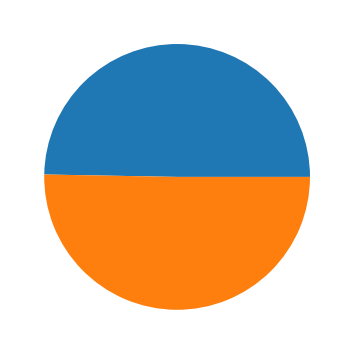

In [ ]:
print(f"Positive engagements are: {int(n_positive_engagements):n} ({int(n_positive_engagements)/n_engagements:.4f}%)")
print(f"Negative engagements are: {int(n_negative_engagements):n} ({int(n_negative_engagements)/n_engagements:.4f}%)")
print(f"Like engagements are: {int(n_like_engagements):n} ({int(n_like_engagements)/n_engagements:.4f}%)")
print(f"Retweet engagements are: {int(n_retweet_engagements):n} ({int(n_retweet_engagements)/n_engagements:.4f}%)")
print(f"Reply engagements are: {int(n_reply_engagements):n} ({int(n_reply_engagements)/n_engagements:.4f}%)")
print(f"Comment engagements are: {int(n_comment_engagements):n} ({int(n_comment_engagements)/n_engagements:.4f}%)")
plt.pie([n_positive_engagements, n_negative_engagements])
plt.show()

## Number of rows that involves more than one engagement

In [ ]:
dataframe['number_of_engagements'] = dataframe[[
    "tweet_feature_engagement_is_like",
    "tweet_feature_engagement_is_retweet",
    "tweet_feature_engagement_is_reply",
    "tweet_feature_engagement_is_comment",
]].sum(axis=1).astype(np.uint8)
dataframe['number_of_engagements']

0         0
1         0
2         1
3         0
4         1
         ..
116119    2
116120    1
116121    0
116122    1
116123    0
Name: number_of_engagements, Length: 9056311, dtype: uint8

Min number of different engagement types in a row: 0
Max number of different engagement types in a row: 4
Mean number of different engagement types in a row: 0.5205


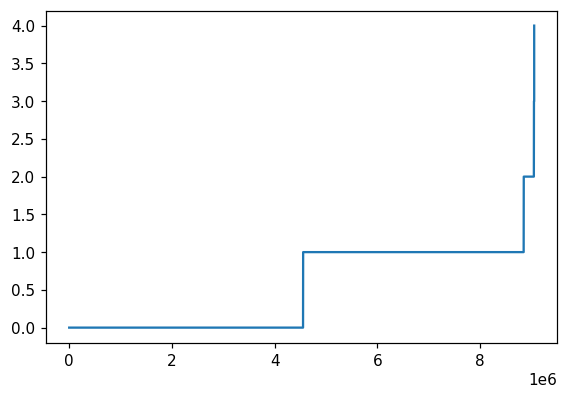

In [ ]:
print(f"Min number of different engagement types in a row: {dataframe['number_of_engagements'].min()}")
print(f"Max number of different engagement types in a row: {dataframe['number_of_engagements'].max()}")
print(f"Mean number of different engagement types in a row: {dataframe['number_of_engagements'].mean():.4f}")

# Plotting the result
plt.clf()
plt.plot(dataframe['number_of_engagements'].sort_values().values.get())
plt.show()

In [ ]:
engagements_value_count = dataframe['number_of_engagements'].value_counts()
engagements_value_count.values

array([4554366, 4296724,  198707,    6411,     103], dtype=int32)

Rows with 0 engagements are 4554366 (0.5029%)
Rows with 1 engagements are 4296724 (0.4744%)
Rows with 2 engagements are 198707 (0.0219%)
Rows with 3 engagements are 6411 (0.0007%)
Rows with 4 engagements are 103 (0.0000%)


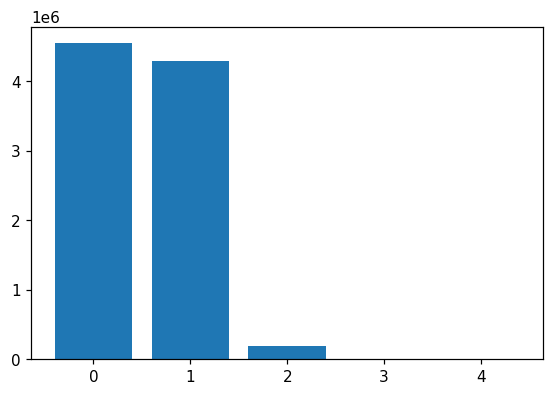

In [ ]:
for i in range(5):
    print(f"Rows with {i} engagements are {engagements_value_count[i]:n} ({engagements_value_count[i]/n_engagements:.4f}%)")
# Plotting the result
plt.bar(engagements_value_count.index.values.get(), engagements_value_count.values.get())
plt.show()

## Let's do the same thing for each language

In [ ]:
dataframe['language'] 

0         20
1         47
2         47
3         47
4         62
          ..
116119    49
116120    62
116121    62
116122    62
116123    49
Name: language, Length: 9056311, dtype: uint32

In [ ]:
language_dictionary = dataframe['language'].unique()
language_dictionary.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
      dtype=uint32)

In [ ]:
# Declaring some auxiliary structures
n_engagements_arr = np.empty(len(language_dictionary.values))
n_positive_engagements_arr = np.empty(len(language_dictionary.values))
n_negative_engagements_arr = np.empty(len(language_dictionary.values))
n_like_engagements_arr = np.empty(len(language_dictionary.values))
n_retweet_engagements_arr = np.empty(len(language_dictionary.values))
n_reply_engagements_arr = np.empty(len(language_dictionary.values))
n_comment_engagements_arr = np.empty(len(language_dictionary.values))

In [ ]:
for language_id in language_dictionary.values:
    # To short things
    i = language_id.get()
    sub_dataframe = dataframe[dataframe['language'] == i]
    # Printing the info computated
    n_engagements_arr[i-1] = len(sub_dataframe)
    n_positive_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_positive'].astype('int32').sum()
    n_negative_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_negative'].astype('int32').sum()
    n_like_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_like'].astype('int32').sum()
    n_retweet_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_retweet'].astype('int32').sum()
    n_reply_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_reply'].astype('int32').sum()
    n_comment_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_comment'].astype('int32').sum()

#### Language popularity (X = language_id | Y = number of rows with a tweet in that language)

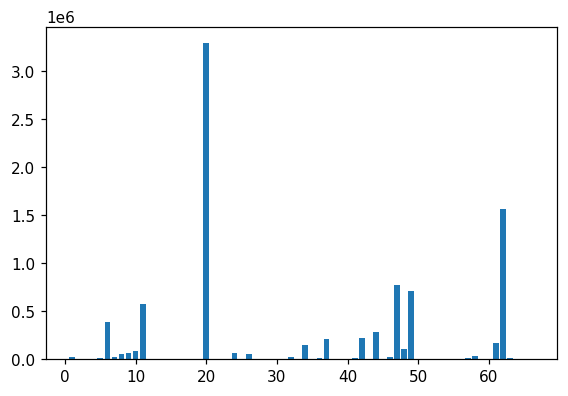

In [ ]:
plt.bar(language_dictionary.values.get(), n_engagements_arr)
plt.show()

<BarContainer object of 66 artists>

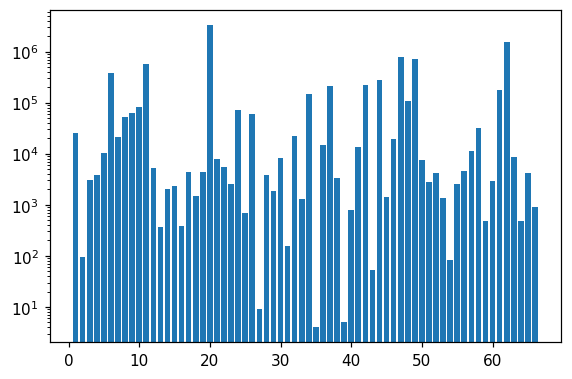

In [ ]:
# In logaritmic scale
plt.yscale('log')
plt.bar(language_dictionary.values.get(), n_engagements_arr)

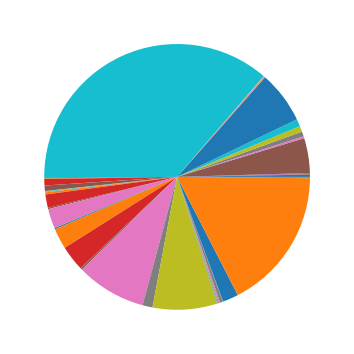

In [ ]:
plt.pie(n_engagements_arr)
plt.show()

In [ ]:
for i, count in enumerate(n_engagements_arr):
    print(f"Language {i+1} has {int(count):n} rows")

Language 1 has 24990 rows
Language 2 has 95 rows
Language 3 has 3041 rows
Language 4 has 3827 rows
Language 5 has 10423 rows
Language 6 has 384036 rows
Language 7 has 21210 rows
Language 8 has 53629 rows
Language 9 has 62820 rows
Language 10 has 81468 rows
Language 11 has 575523 rows
Language 12 has 5157 rows
Language 13 has 363 rows
Language 14 has 2060 rows
Language 15 has 2371 rows
Language 16 has 380 rows
Language 17 has 4383 rows
Language 18 has 1505 rows
Language 19 has 4349 rows
Language 20 has 3293806 rows
Language 21 has 8065 rows
Language 22 has 5477 rows
Language 23 has 2516 rows
Language 24 has 70368 rows
Language 25 has 686 rows
Language 26 has 59210 rows
Language 27 has 9 rows
Language 28 has 3892 rows
Language 29 has 1880 rows
Language 30 has 8308 rows
Language 31 has 155 rows
Language 32 has 22754 rows
Language 33 has 1289 rows
Language 34 has 147246 rows
Language 35 has 4 rows
Language 36 has 14546 rows
Language 37 has 213563 rows
Language 38 has 3393 rows
Language 39 

## Percentage of engagement type for each language (red line is the percentage computed using all languages)

POSITIVE


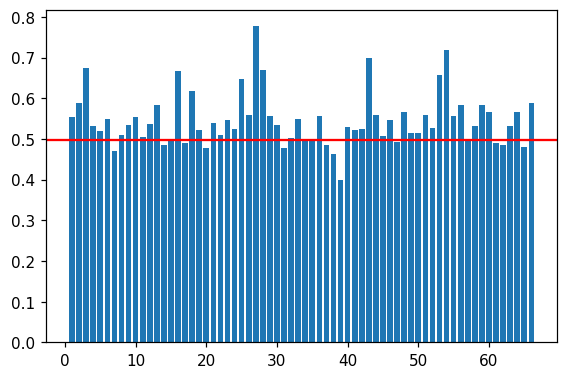

In [ ]:
# Positive
print("POSITIVE")
percentage = n_positive_engagements_arr / n_engagements_arr
plt.bar(language_dictionary.values.get(), percentage)
plt.axhline(n_positive_engagements/n_engagements, color="red")
plt.show()

NEGATIVE


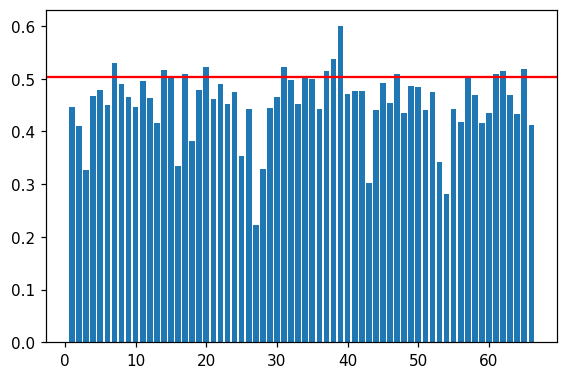

In [ ]:
# Negative
print("NEGATIVE")
percentage = n_negative_engagements_arr / n_engagements_arr
plt.bar(language_dictionary.values.get(), percentage)
plt.axhline(n_negative_engagements/n_engagements, color="red")
plt.show()

LIKE


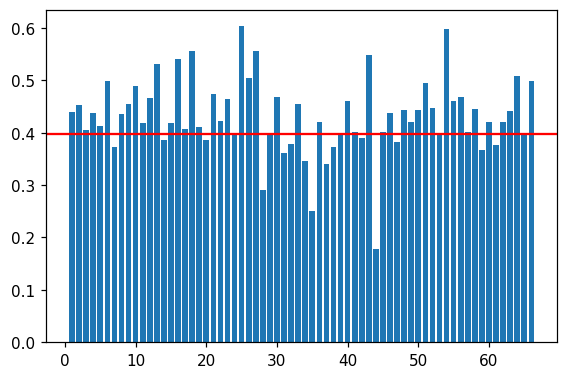

In [ ]:
# Like
print("LIKE")
percentage = n_like_engagements_arr / n_engagements_arr
plt.bar(language_dictionary.values.get(), percentage)
plt.axhline(n_like_engagements/n_engagements, color="red")
plt.show()

RETWEET


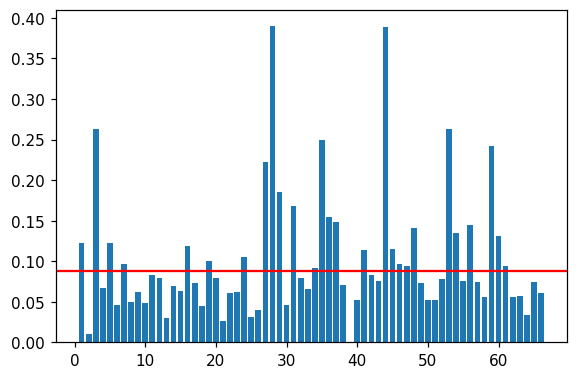

In [ ]:
# Retweet
print("RETWEET")
percentage = n_retweet_engagements_arr / n_engagements_arr
plt.bar(language_dictionary.values.get(), percentage)
plt.axhline(n_retweet_engagements/n_engagements, color="red")
plt.show()

REPLY


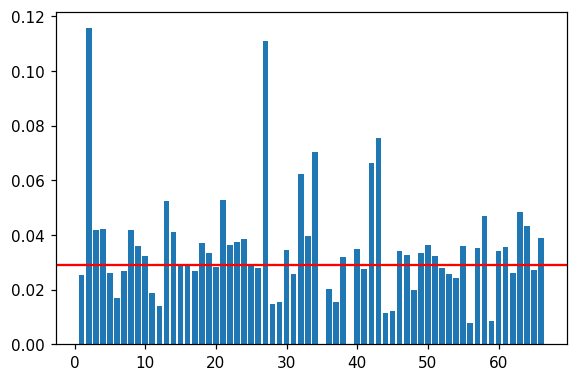

In [ ]:
# Reply
print("REPLY")
percentage = n_reply_engagements_arr / n_engagements_arr
plt.bar(language_dictionary.values.get(), percentage)
plt.axhline(n_reply_engagements/n_engagements, color="red")
plt.show()

COMMENT


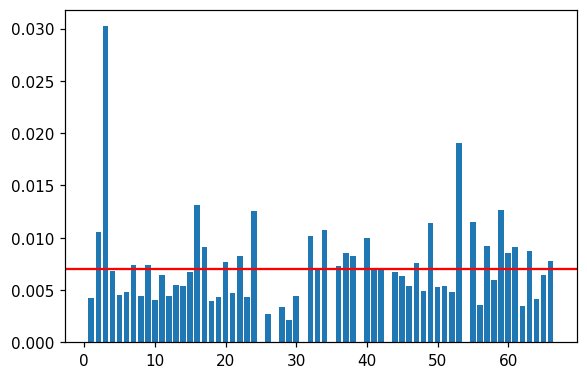

In [ ]:
# Comment
print("COMMENT")
percentage = n_comment_engagements_arr / n_engagements_arr
plt.bar(language_dictionary.values.get(), percentage)
plt.axhline(n_comment_engagements/n_engagements, color="red")
plt.show()

## Let's do the same thing for each the tweet type

In [ ]:
# I included Reply because it's listed on https://recsys-twitter.com/
t_types = ['Quote', 'Retweet', 'TopLevel', 'Reply', ]
# NB check encoding
t_types_dict = {'TopLevel': 3, 'Reply': 4, 'Retweet': 2, 'Quote':1}

pd.set_option('display.max_rows', 500)
dataframe.head(50)

,hashtags_count_t,domains_count_t,links_count_t,media,hashtags,domains,links,language,tweet_type,tweet_id,a_user_id,b_user_id,reply,retweet,retweet_comment,like,timestamp_wd,tweet_feature_engagement_is_reply,tweet_feature_engagement_is_retweet,tweet_feature_engagement_is_comment,tweet_feature_engagement_is_like,timestamp_hour,timestamp_minute,timestamp_second,tweet_type_raw,timestamp,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a,tweet_feature_engagement_is_positive,tweet_feature_engagement_is_negative,number_of_engagements
0,0,0,0,0,1,1,1,20,2,2883132,2513097,824160,0,0,0,0,5,0,0,0,0,17,23,54,Retweet,1613237034,2473,662,False,1261859734,169,339,False,1520886748,False,0,1,0
1,0,1,1,0,1,66233,113401,47,3,1334478,2570055,2579677,0,0,0,0,4,0,0,0,0,15,30,0,TopLevel,1613748600,4418640,228,True,1266804490,393,1190,False,1237570695,False,0,1,0
2,0,1,1,0,1,89689,518494,47,3,3696548,51913,4887078,0,0,0,1613388292,0,0,0,0,1,10,50,38,TopLevel,1613386238,219715,3685,True,1202617218,629,1473,False,1263176351,False,1,0,1
3,0,0,0,0,1,1,1,47,2,6214352,520585,4204396,0,0,0,0,4,0,0,0,0,4,24,0,Retweet,1613708640,2388283,13511,True,1251645191,123,200,False,1268276559,False,0,1,0
4,0,0,0,6,1,1,1,62,3,1369771,2450631,95473,0,0,0,1612587384,5,0,0,0,1,4,33,38,TopLevel,1612586018,414,720,False,1578273274,134,379,False,1483862063,True,1,0,1
5,0,0,0,0,1,1,1,11,1,6899501,344779,2294250,0,0,0,0,3,0,0,0,0,12,40,51,Quote,1613047251,673,561,False,1318013852,2322,996,False,1385942383,True,0,1,0
6,0,0,0,0,1,1,1,20,2,6113270,3287803,1181513,0,0,0,0,0,0,0,0,0,10,3,49,Retweet,1613383429,9879,95,False,1551982041,61,1008,False,1573893335,False,0,1,0
7,0,0,0,0,1,1,1,20,1,3702352,456052,297643,0,0,0,1614134640,2,0,0,0,1,2,10,56,Quote,1614132656,209681,141,False,1516334262,35,106,False,1581377629,False,1,0,1
8,0,0,0,0,1,1,1,47,2,6867952,328331,2308414,0,0,0,0,2,0,0,0,0,15,5,38,Retweet,1614179138,901,782,False,1401492344,9661,8573,False,1373060291,True,0,1,0
9,0,1,1,0,1,103044,524525,62,3,4482019,38756,4067366,0,0,0,1614175309,2,0,0,0,1,13,12,53,TopLevel,1614172373,881,583,False,1254934130,355,650,False,1589197420,False,1,0,1


In [ ]:
# Declaring some auxiliary structures
n_engagements_arr = np.empty(len(t_types))
n_positive_engagements_arr = np.empty(len(t_types))
n_negative_engagements_arr = np.empty(len(t_types))
n_like_engagements_arr = np.empty(len(t_types))
n_retweet_engagements_arr = np.empty(len(t_types))
n_reply_engagements_arr = np.empty(len(t_types))
n_comment_engagements_arr = np.empty(len(t_types))

In [ ]:
for i in t_types_dict.values():
    sub_dataframe = dataframe[dataframe['tweet_type'] == i]
    # Printing the info computated
    n_engagements_arr[i-1] = len(sub_dataframe)
    n_positive_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_positive'].astype('int32').sum()
    n_negative_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_negative'].astype('int32').sum()
    n_like_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_like'].astype('int32').sum()
    n_retweet_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_retweet'].astype('int32').sum()
    n_reply_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_reply'].astype('int32').sum()
    n_comment_engagements_arr[i-1] = sub_dataframe['tweet_feature_engagement_is_comment'].astype('int32').sum()

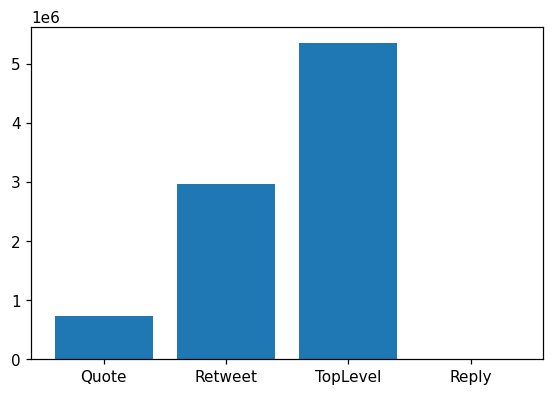

In [ ]:
plt.bar(t_types, n_engagements_arr)
plt.show()

POSITIVE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


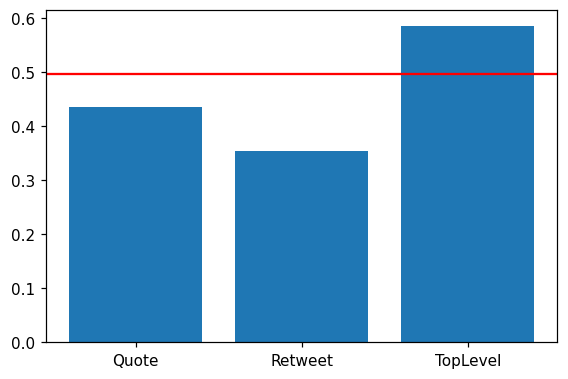

In [ ]:
# Positive
print("POSITIVE")
percentage = n_positive_engagements_arr / n_engagements_arr
plt.bar(t_types, percentage)
plt.axhline(n_positive_engagements/n_engagements, color="red")
plt.show()

NEGATIVE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


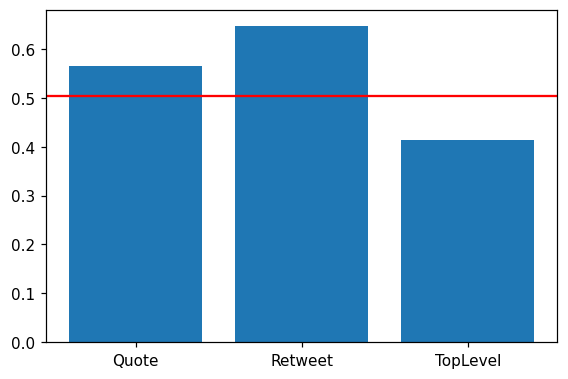

In [ ]:
# Negative
print("NEGATIVE")
percentage = n_negative_engagements_arr / n_engagements_arr
plt.bar(t_types, percentage)
plt.axhline(n_negative_engagements/n_engagements, color="red")
plt.show()

LIKE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


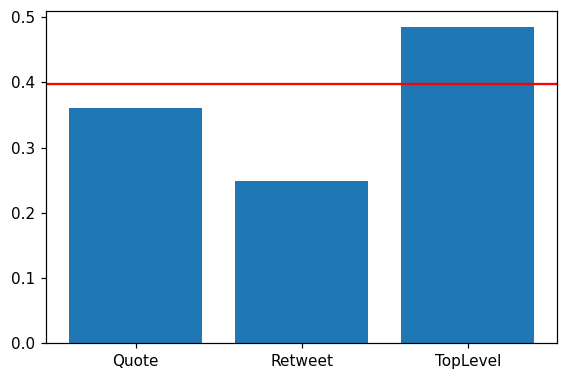

In [ ]:
# Like
print("LIKE")
percentage = n_like_engagements_arr / n_engagements_arr
plt.bar(t_types, percentage)
plt.axhline(n_like_engagements/n_engagements, color="red")
plt.show()

RETWEET


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


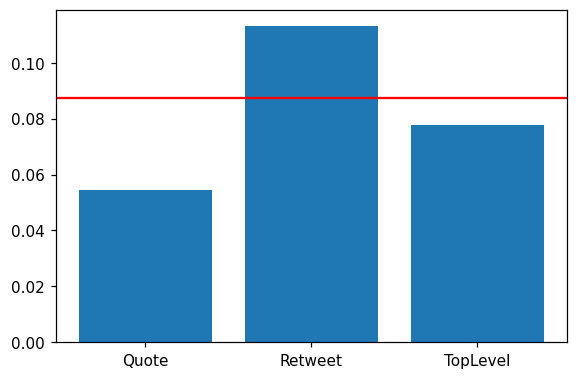

In [ ]:
# Retweet
print("RETWEET")
percentage = n_retweet_engagements_arr / n_engagements_arr
plt.bar(t_types, percentage)
plt.axhline(n_retweet_engagements/n_engagements, color="red")
plt.show()

REPLY


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


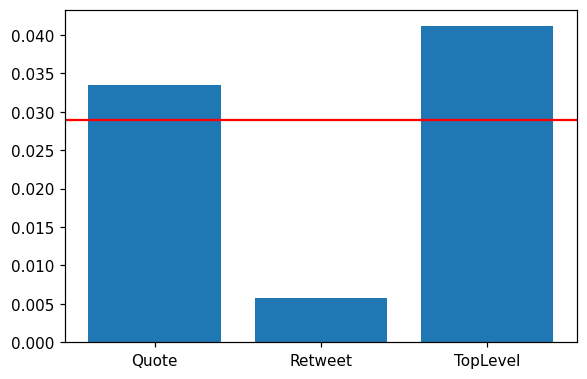

In [ ]:
# Reply
print("REPLY")
percentage = n_reply_engagements_arr / n_engagements_arr
plt.bar(t_types, percentage)
plt.axhline(n_reply_engagements/n_engagements, color="red")
plt.show()

COMMENT


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


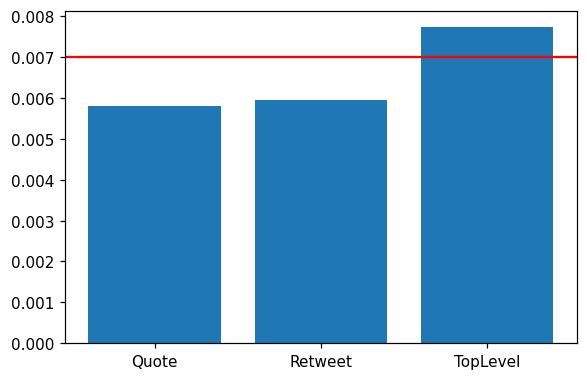

In [ ]:
# Comment
print("COMMENT")
percentage = n_comment_engagements_arr / n_engagements_arr
plt.bar(t_types, percentage)
plt.axhline(n_comment_engagements/n_engagements, color="red")
plt.show()